In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
df = pd.read_csv('IMDB.csv')
df = df.dropna()
df = df

In [3]:
df['sentiment'].replace({'positive': 1, 'negative': 0}, inplace=True)
def clean_string(text):
  cleaned_text = re.sub(r"[^a-zA-Z0-9., ]", "", text)
  return cleaned_text
df = df.dropna()
df['review'] = df['review'].apply(clean_string)
df

C:\Users\Mohd Arshil\AppData\Local\Temp\ipykernel_27584\495735256.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].replace({'positive': 1, 'negative': 0}, inplace=True)
C:\Users\Mohd Arshil\AppData\Local\Temp\ipykernel_27584\495735256.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. br br The filmi...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
len(tokenizer.word_counts)

151194

In [5]:
tokens = tokenizer.texts_to_sequences(df['review'])
sequences = tf.keras.preprocessing.sequence.pad_sequences(tokens, padding='post', maxlen=400)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. br br The filmi...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,Im going to have to disagree with the previous...,0


In [6]:
len(sequences[5]), len(sequences[10])

(400, 400)

In [7]:
X, y = sequences, df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 400), (10000, 400), (40000,), (10000,))

In [8]:
from tensorflow.keras import callbacks

In [14]:
m = keras.Sequential(
    [
    layers.Embedding(input_dim=151195, output_dim=32, embeddings_regularizer=tf.keras.regularizers.l2(1e-3)),
    layers.SpatialDropout1D(0.2),

    layers.Bidirectional(layers.LSTM(64, return_sequences=False, 
                                  kernel_regularizer=keras.regularizers.l2(1e-3),
                                  recurrent_regularizer=keras.regularizers.l2(1e-3))),
    #layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # layers.Bidirectional(layers.GRU(32, return_sequences=False,
    #                               kernel_regularizer=keras.regularizers.l2(1e-4),
    #                               recurrent_regularizer=keras.regularizers.l2(1e-4))),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),


    # layers.Dense(16, activation='relu',
    #             kernel_regularizer=keras.regularizers.l2(1e-4)),
    # layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
    ]
)
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    min_delta=0.01
)

In [15]:
m.fit(X_train, y_train, validation_split=0.15, epochs=5, batch_size=64, callbacks=[early_stopping])

Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 198s 181ms/step - AUC: 0.6481 - accuracy: 0.5989 - loss: 0.9765 - val_AUC: 0.8931 - val_accuracy: 0.8200 - val_loss: 0.5647
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 197s 185ms/step - AUC: 0.8888 - accuracy: 0.8223 - loss: 0.5695 - val_AUC: 0.9099 - val_accuracy: 0.8363 - val_loss: 0.5555
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 208s 196ms/step - AUC: 0.9031 - accuracy: 0.8313 - loss: 0.5551 - val_AUC: 0.8711 - val_accuracy: 0.7202 - val_loss: 0.7248


In [18]:
ypred = m.predict(X_test)
ypred = np.round(ypred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, ypred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


0.8157

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


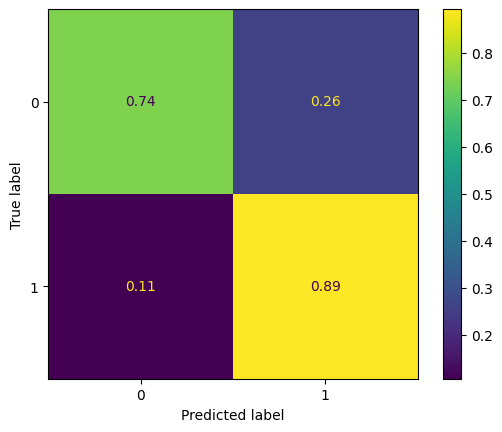

In [20]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, np.round(m.predict(X_test)), normalize='true'))
cm.plot()

In [21]:
m.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 400, 32)        │     4,838,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 400, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,664,101 (55.94 MB)

 Trainable params: 4,888,033 (18.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,776,068 (37.29 MB)